In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import time
warnings.filterwarnings('ignore')

In [2]:
# from catboost import CatBoostRegressor #catboost梯度提升算法

In [3]:
t1 = time.time()
path ='data1'

In [4]:
fund_returnA =  pd.read_csv(path+'/test_fund_return.csv')
fund_returnB =  pd.read_csv(path+'/train_fund_return.csv')
fund_return = pd.merge(fund_returnB,fund_returnA,how='left')

In [5]:
benchmark_returnA =  pd.read_csv(path+'/test_fund_benchmark_return.csv')
benchmark_returnB =  pd.read_csv(path+'/train_fund_benchmark_return.csv')
benchmark_return = pd.merge(benchmark_returnB,benchmark_returnA,how='left')

In [20]:
test_correlation = pd.read_csv(path+'/test_correlation.csv')
train_correlation = pd.read_csv(path+'/train_correlation.csv')
df_test = pd.merge(train_correlation,test_correlation,how='left')

In [21]:
index_returnA = pd.read_csv(path+'/test_index_return.csv',encoding='GBK')
index_returnB =  pd.read_csv(path+'/train_index_return.csv',encoding='GBK')
index_return = pd.merge(index_returnB,index_returnA,how='left')

In [22]:
ID = df_test['Unnamed: 0']
df_test.drop(['Unnamed: 0'],axis=1,inplace=True)

In [23]:
index = pd.concat([ID.map(lambda x:x.split('-')[0]),ID.map(lambda x:x.split('-')[1])],axis=1)
index.columns = ['FundA','FundB']

In [24]:
def lgbPRD(x_train,target,val,val2,x_test,params,num_boost_round=10000):
    import lightgbm as lgb
    #xgb矩阵转换
    xg_train = lgb.Dataset(np.array(x_train),target)


    bst = lgb.train(params, xg_train,num_boost_round)
    
    
    return bst.predict( x_test ),bst.predict( val ),bst.predict( val2 )


def xgbPRD(x_train,target,val,val2,x_test,params,num_boost_round=5000):
    import xgboost as xgb
    #xgb矩阵转换
    xg_train = xgb.DMatrix(np.array(x_train),target)
    xg_test = xgb.DMatrix(np.array(x_test))
    xg_val = xgb.DMatrix(np.array(val))
    xg_val2 = xgb.DMatrix(np.array(val2))
    #xg_test1 = xgb.DMatrix(np.array(test1))
    #cv调参
    #cv = xgb.cv(params, xg_train, num_boost_round=num_boost_round, nfold=4, seed=2018, stratified=False,
             #early_stopping_rounds=25,verbose_eval=100,feval=myFeval,show_stdv=True)
    #nround = cv.shape[0]
    #训练模型
    bst = xgb.train(params, xg_train,num_boost_round)
    
    
    return bst.predict( xg_test ),bst.predict( xg_val ),bst.predict( xg_val2 )

In [25]:
#定义函数：根据输入的数据集，起止时间，把FundA，FundB的数据提取作为特征
def day_tran(data,star_time,end_time,index=index):
    #先根据index['FundA']匹配A列数据
    fund_r = pd.concat((data['Unnamed: 0'],data[data.columns[star_time:end_time]]),axis=1)
    fund_r.rename(columns={'Unnamed: 0':"FundA"},inplace=True)
    FundA  = pd.merge(index,fund_r,how = 'left')      
    FundA = FundA[FundA.columns[2:]]
    FundA.columns=range(0,FundA.shape[1])
    #再根据index['FundB']匹配B列数据
    fund_r.rename(columns={"FundA":"FundB"},inplace=True)
    FundB = pd.merge(index,fund_r,on = 'FundB',how = 'left',suffixes=('_x', '_y'))
    FundB = FundB[FundB.columns[2:]]
    FundB.columns=range(0,FundB.shape[1])
    return FundA,FundB

In [26]:
#然后运用matplotlib进行特征探索
import matplotlib.pyplot as plt
from pylab import *  

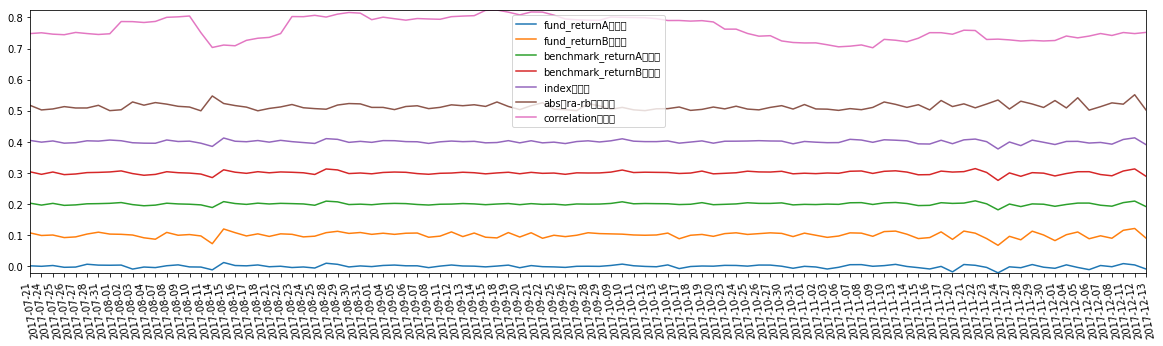

In [27]:
FundA = 0 #选择要观察的基金组合
FundB = 1 #选择要观察的基金组合
start_time=-160
end_time=-61
plt.figure(figsize=(20, 5))
names = fund_returnA.columns[start_time:end_time] #横坐标
x = range(len(names))

feature_day = fund_returnA.columns[start_time-1:end_time-1]#因为我们预测的是第二天的相关性，所以特征要比correlation的数据提前一天

y1 = fund_return[feature_day].loc[FundA]   #基金A fund_return
y2 = fund_return[feature_day].loc[FundB]   #基金B fund_return
y3 = benchmark_return[feature_day].loc[FundA] #基金A benchmark_return
y4 = benchmark_return[feature_day].loc[FundB] #基金B benchmark_return
y5 = index_return[feature_day].mean()

#尝试组合特征，观察与correlation的拟合度（经尝试abs(y-y2)拟合度好，可作为特征）

y6 = abs(y1-y2)*3 #乘以3是为了放大折现的形状以便比较correlation线

yx = df_test[df_test.columns[start_time-end_time:]].loc[FundB-1] #这里观察的需要根据基金的组合进行调整

plt.plot(x, y1, ms=1,label=u'fund_returnA曲线图')
plt.plot(x, y2+0.1, ms=5,label=u'fund_returnB曲线图')
plt.plot(x, y3+0.2, ms=5,label=u'benchmark_returnA曲线图')
plt.plot(x, y4+0.3, ms=1,label=u'benchmark_returnB曲线图')
plt.plot(x, y5+0.4, ms=1,label=u'index曲线图')
plt.plot(x, y6+0.5, ms=1,label=u'abs（ra-rb）曲线图')
plt.plot(x, yx, ms=1,label=u'correlation曲线图')
plt.legend()  # 让图例生效
plt.xticks(x, names, rotation=100)
plt.margins(0)
plt.subplots_adjust(bottom=0.15)

In [28]:
#定义结果评价函数，可通过倒数第2天的correlation数据，预测倒数第1天的correlation，以验证模型效果
from sklearn.metrics import mean_absolute_error  
def modelFeval(y_pred,labels):
    sc1 = mean_absolute_error(labels,y_pred)
    diff = 0
    count = 0
    for i in range(len(y_pred)):
        diff += abs((y_pred[i]-labels[i]) / (1.5-labels[i]))
        count +=1
    sc2 = diff/count
    sc = ((2/(2+sc1+sc2))**2)
    return 'myFeval',float(sc)

In [29]:
day = 300

In [ ]:
for i in tqdm(range(10)):    
    FundA,FundB = day_tran(fund_return,-day-63,-63)
    testA = df_test.mean(axis=1)
    FundAA = FundA.mean(axis=1)
    FundBB =FundB.mean(axis=1)
    x_train = pd.concat([abs(FundA-FundB),testA,FundAA,FundBB,abs(FundAA-FundBB)],axis=1)
    
    if i ==0 :
        xtrain = x_train
        ytrain = df_test[df_test.columns[-3]]
    else:
        xtrain = pd.concat([xtrain,x_train])
        ytrain = pd.concat([ytrain,df_test[df_test.columns[-3-i]]])

 50%|█████     | 5/10 [01:10<01:15, 15.16s/it]

In [14]:
FundA,FundB = day_tran(fund_return,-day,None)
testA = df_test.mean(axis=1)
FundAA = FundA.mean(axis=1)
FundBB =FundB.mean(axis=1)
x_test = pd.concat([abs(FundA-FundB),testA,FundAA,FundBB,abs(FundAA-FundBB)],axis=1)
q = x_test.mean()
x_test = x_test.fillna(0).replace(0,q)

FundA,FundB = day_tran(fund_return,-day-61,-61)
testA = df_test.mean(axis=1)
FundAA = FundA.mean(axis=1)
FundBB =FundB.mean(axis=1)
xval = pd.concat([abs(FundA-FundB),testA,FundAA,FundBB,abs(FundAA-FundBB)],axis=1)
q = xval.mean()
xval1 = xval.fillna(0).replace(0,q)

FundA,FundB = day_tran(fund_return,-day-62,-62)
testA = df_test.mean(axis=1)
FundAA = FundA.mean(axis=1)
FundBB =FundB.mean(axis=1)
xval = pd.concat([abs(FundA-FundB),testA,FundAA,FundBB,abs(FundAA-FundBB)],axis=1)
q = xval.mean()
xval2 = xval.fillna(0).replace(0,q)

In [15]:
xtrain.shape,ytrain.shape,x_test.shape,xval1.shape,xval2.shape

((2610030, 304), (2610030,), (261003, 304), (261003, 304), (261003, 304))

In [16]:
lgb_params = {
 #   'device':'gpu',
    'application':'regression_l1',
    'seed': 0,
    'learning_rate':0.01,
    'max_depth':1,
    'feature_fraction':0.8,
    'lambda_l1':2,
}

xgb_params = {
    'seed': 0,
    'silent': 1,
    'learning_rate': 0.1,
#     'objective': 'gpu:reg:linear',
    'objective': 'reg:linear',
    'max_depth': 1,
    'eval_metric': 'rmse',
    'nthread':-1,
#     'tree_method':"gpu_hist",
    'subsample':0.8,
    'alpha':50,
    'colsample_bytree':0.6,
    'lambda':4,
}

In [17]:
lgypred,lgyval1,lgyval2 = lgbPRD(xtrain,ytrain,xval1,xval2,x_test,lgb_params,900)
ypred,yval1,yval2 = xgbPRD(xtrain,ytrain,xval1,xval2,x_test,xgb_params,1100)

In [18]:
modelFeval(lgyval1,df_test[df_test.columns[-1]])
modelFeval(yval1,df_test[df_test.columns[-1]])

('myFeval', 0.8294427113473177)

In [19]:
#融合lgb和xgb预测结果作为特征，进行预测
xstack = np.vstack([yval1,lgyval1]).T
vstack = np.vstack([yval2,lgyval2]).T
tstack = np.vstack([ypred,lgypred]).T

In [20]:
lgbs_params = {
    'seed': 0,
    'application':'regression_l1',
    'boosting':'gbdt',
    #'device':'gpu',
    'learning_rate': 0.01,
    'max_depth':1,
    'feature_fraction':0.7,
    'bagging_fraction':0.6,
    'bagging_freq':1,
    'lambda_l1':1,
}

In [21]:
stack_pred,stack_val,stack_val1 = lgbPRD(xstack,df_test[df_test.columns[-1]],vstack,vstack,tstack,lgbs_params,1000)

In [22]:
modelFeval(stack_val,df_test[df_test.columns[-1]])

('myFeval', 0.8408443423730565)

In [23]:
df = pd.DataFrame({'ID':ID,'value':stack_pred})

In [24]:
df.to_csv('base_11_11.csv',index=None)

In [25]:
df

,ID,value
0,Fund 1-Fund 2,0.820631
1,Fund 1-Fund 3,0.780322
2,Fund 1-Fund 4,0.712090
3,Fund 1-Fund 5,0.793364
4,Fund 1-Fund 6,0.654602
5,Fund 1-Fund 7,0.805215
6,Fund 1-Fund 8,0.722024
7,Fund 1-Fund 9,0.785973
8,Fund 1-Fund 10,0.756977
9,Fund 1-Fund 11,0.828750


In [26]:
t2=time.time()
print("the project is done and time use:",t2-t1)

the project is done and time use: 14849.10432267189
